# Pipelines para Análisis de Salud y Estilo de Vida

Este notebook implementa pipelines de procesamiento de datos y machine learning para el análisis de datos de salud y estilo de vida. Se incluyen las siguientes secciones:

1. Configuración del entorno y carga de librerías
2. Carga y exploración inicial de datos
3. Preprocesamiento y limpieza
4. Feature engineering
5. Entrenamiento y evaluación de modelos
6. Despliegue y pruebas

In [1]:
# Importar librerías necesarias
import numpy as np
import pandas as pd
from pathlib import Path
import logging
from datetime import datetime

# Librerías de scikit-learn para preprocesamiento y pipelines
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV

# Librerías para modelos
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

# Métricas y evaluación
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# Configuración de logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Verificar versiones de las librerías principales
import sklearn
print(f"scikit-learn version: {sklearn.__version__}")
print(f"pandas version: {pd.__version__}")
print(f"numpy version: {np.__version__}")

scikit-learn version: 1.7.2
pandas version: 2.2.3
numpy version: 2.1.1


## Carga de Datos

Cargaremos el dataset desde el archivo CSV y realizaremos una inspección inicial de los datos.

In [2]:
# Definir la ruta al archivo de datos
data_path = Path('../datos/Lifestyle_and_Health_Risk_Prediction_Synthetic_Dataset.csv')

# Cargar los datos
try:
    df = pd.read_csv(data_path)
    logger.info(f"Datos cargados exitosamente. Shape: {df.shape}")
except Exception as e:
    logger.error(f"Error al cargar los datos: {str(e)}")
    raise

# Mostrar información básica del dataset
print("\nInformación del dataset:")
print(df.info())

print("\nPrimeras filas del dataset:")
print(df.head())

print("\nEstadísticas descriptivas:")
print(df.describe())

2025-10-29 22:05:23,911 - __main__ - INFO - Datos cargados exitosamente. Shape: (5000, 12)



Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           5000 non-null   int64  
 1   weight        5000 non-null   int64  
 2   height        5000 non-null   int64  
 3   exercise      5000 non-null   object 
 4   sleep         5000 non-null   float64
 5   sugar_intake  5000 non-null   object 
 6   smoking       5000 non-null   object 
 7   alcohol       5000 non-null   object 
 8   married       5000 non-null   object 
 9   profession    5000 non-null   object 
 10  bmi           5000 non-null   float64
 11  health_risk   5000 non-null   object 
dtypes: float64(2), int64(3), object(7)
memory usage: 468.9+ KB
None

Primeras filas del dataset:
   age  weight  height exercise  sleep sugar_intake smoking alcohol married  \
0   56      67     195      low    6.1       medium     yes     yes     yes   
1   69   

In [5]:
print("\nNombres de las columnas:")
print(df.columns.tolist())


Nombres de las columnas:
['age', 'weight', 'height', 'exercise', 'sleep', 'sugar_intake', 'smoking', 'alcohol', 'married', 'profession', 'bmi', 'health_risk']


## Preprocesamiento de Datos

Crearemos un pipeline de preprocesamiento que incluya:
1. Manejo de valores faltantes
2. Codificación de variables categóricas
3. Escalado de variables numéricas

In [6]:
# Identificar columnas numéricas y categóricas
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

# Remover la variable objetivo si está en alguna de las listas
target_column = 'health_risk'
if target_column in numeric_features:
    numeric_features.remove(target_column)
if target_column in categorical_features:
    categorical_features.remove(target_column)

# Crear transformadores para cada tipo de datos
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# Crear el preprocessor usando ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Crear el pipeline completo
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Dividir los datos en entrenamiento y prueba
X = df.drop(target_column, axis=1)
y = df[target_column]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

logger.info("Dimensiones de los conjuntos de datos:")
logger.info(f"X_train: {X_train.shape}")
logger.info(f"X_test: {X_test.shape}")
logger.info(f"Distribución de clases en entrenamiento:\n{y_train.value_counts(normalize=True)}")
logger.info(f"Distribución de clases en prueba:\n{y_test.value_counts(normalize=True)}")

2025-10-29 22:06:32,314 - __main__ - INFO - Dimensiones de los conjuntos de datos:
2025-10-29 22:06:32,315 - __main__ - INFO - X_train: (4000, 11)
2025-10-29 22:06:32,317 - __main__ - INFO - X_test: (1000, 11)
2025-10-29 22:06:32,319 - __main__ - INFO - Distribución de clases en entrenamiento:
health_risk
high    0.698
low     0.302
Name: proportion, dtype: float64
2025-10-29 22:06:32,321 - __main__ - INFO - Distribución de clases en prueba:
health_risk
high    0.698
low     0.302
Name: proportion, dtype: float64


## Entrenamiento y Evaluación del Modelo

Ahora entrenaremos el modelo usando el pipeline creado y evaluaremos su rendimiento.

2025-10-29 22:06:40,249 - __main__ - INFO - Iniciando búsqueda de hiperparámetros...


Fitting 5 folds for each of 12 candidates, totalling 60 fits


2025-10-29 22:06:49,709 - __main__ - INFO - Mejores parámetros: {'classifier__max_depth': 20, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
2025-10-29 22:06:49,710 - __main__ - INFO - Mejor score CV: 0.9753



Reporte de clasificación:
              precision    recall  f1-score   support

        high       0.99      0.98      0.99       698
         low       0.96      0.99      0.97       302

    accuracy                           0.98      1000
   macro avg       0.97      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000



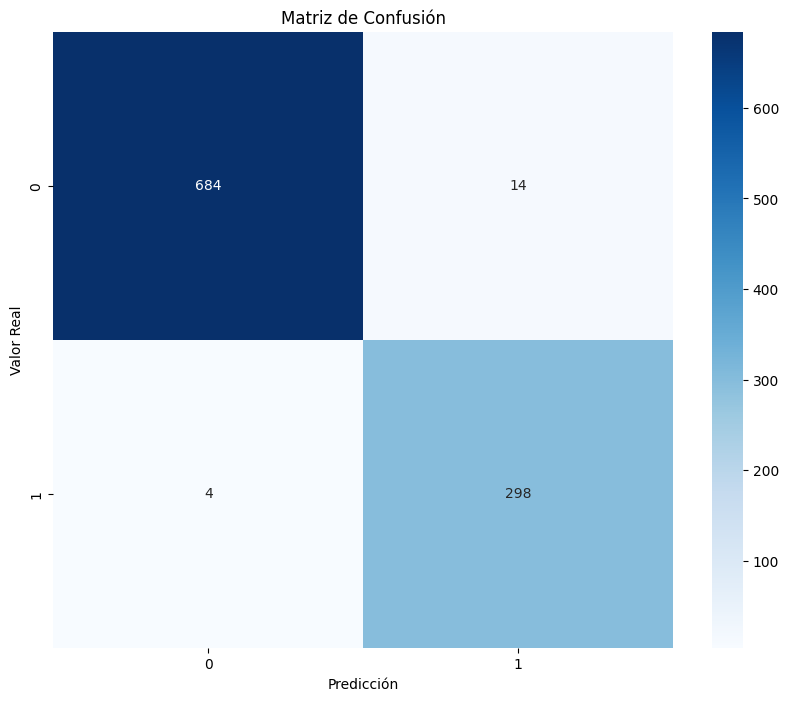

In [7]:
# Definir grid de hiperparámetros
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5]
}

# Crear GridSearchCV
grid_search = GridSearchCV(
    model_pipeline,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

# Entrenar el modelo con búsqueda de hiperparámetros
logger.info("Iniciando búsqueda de hiperparámetros...")
grid_search.fit(X_train, y_train)

# Mostrar mejores parámetros y score
logger.info(f"Mejores parámetros: {grid_search.best_params_}")
logger.info(f"Mejor score CV: {grid_search.best_score_:.4f}")

# Evaluar en conjunto de prueba
y_pred = grid_search.predict(X_test)

# Imprimir reporte de clasificación
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

# Crear matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.ylabel('Valor Real')
plt.xlabel('Predicción')
plt.show()

## Guardado del Modelo

Guardaremos el pipeline entrenado para su uso posterior.

In [8]:
import joblib
from datetime import datetime

# Crear directorio para modelos si no existe
model_dir = Path('../models')
model_dir.mkdir(exist_ok=True)

# Guardar el modelo con timestamp
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_filename = model_dir / f'health_risk_pipeline_{timestamp}.joblib'

# Guardar el pipeline completo
joblib.dump(grid_search.best_estimator_, model_filename)
logger.info(f"Modelo guardado en: {model_filename}")

# Ejemplo de carga y predicción
loaded_model = joblib.load(model_filename)
sample_prediction = loaded_model.predict(X_test[:5])
print("\nPredicciones de ejemplo con el modelo cargado:")
print(sample_prediction)

2025-10-29 22:07:04,654 - __main__ - INFO - Modelo guardado en: ..\models\health_risk_pipeline_20251029_220704.joblib



Predicciones de ejemplo con el modelo cargado:
['low' 'high' 'low' 'high' 'high']


## Creación de ColumnTransformer Personalizado

Vamos a crear un ColumnTransformer más detallado que maneje diferentes tipos de transformaciones según las características específicas de nuestros datos:

1. Variables numéricas continuas (edad, peso, altura, etc.)
2. Variables numéricas discretas (horas de sueño, consumo de azúcar)
3. Variables categóricas ordinales (nivel de ejercicio)
4. Variables categóricas nominales (profesión, estado civil)
5. Variables binarias (fumador, alcohol)

In [20]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

# Definir las columnas según su tipo (ajustado según los tipos de datos reales)
continuous_features = ['age', 'height', 'bmi']  # Variables numéricas continuas
discrete_features = ['weight', 'sleep', 'sugar_intake']  # Variables numéricas discretas
ordinal_features = ['exercise']  # Variables categóricas ordinales
nominal_features = ['profession', 'married']  # Variables categóricas nominales
binary_features = ['smoking', 'alcohol']  # Variables binarias ya convertidas a números

# Pipeline para variables continuas
continuous_transformer = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

# Pipeline para variables discretas
discrete_transformer = make_pipeline(
    SimpleImputer(strategy='median'),
    MinMaxScaler()
)

# Pipeline para variables ordinales
exercise_levels = ['none', 'light', 'moderate', 'intense']
ordinal_transformer = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='none'),
    OrdinalEncoder(categories=[exercise_levels], handle_unknown='use_encoded_value', unknown_value=-1)
)

# Pipeline para variables nominales y binarias combinadas
categorical_features = nominal_features + binary_features
categorical_transformer = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='unknown'),
    OneHotEncoder(drop='first', handle_unknown='ignore')
)

# Crear el ColumnTransformer
preprocessor = make_column_transformer(
    (continuous_transformer, continuous_features),
    (discrete_transformer, discrete_features),
    (ordinal_transformer, ordinal_features),
    (categorical_transformer, categorical_features),
    remainder='drop'  # Eliminar cualquier otra columna
)

# Mostrar la estructura del ColumnTransformer
print("Estructura del ColumnTransformer:")
print("\n1. Transformador para variables continuas:")
print(f"   Columnas: {continuous_features}")
print(f"   Pipeline: {continuous_transformer.steps}")

print("\n2. Transformador para variables discretas:")
print(f"   Columnas: {discrete_features}")
print(f"   Pipeline: {discrete_transformer.steps}")

print("\n3. Transformador para variables ordinales:")
print(f"   Columnas: {ordinal_features}")
print(f"   Pipeline: {ordinal_transformer.steps}")

print("\n4. Transformador para variables categóricas (nominales y binarias):")
print(f"   Columnas: {categorical_features}")
print(f"   Pipeline: {categorical_transformer.steps}")

Estructura del ColumnTransformer:

1. Transformador para variables continuas:
   Columnas: ['age', 'height', 'bmi']
   Pipeline: [('simpleimputer', SimpleImputer(strategy='median')), ('standardscaler', StandardScaler())]

2. Transformador para variables discretas:
   Columnas: ['weight', 'sleep', 'sugar_intake']
   Pipeline: [('simpleimputer', SimpleImputer(strategy='median')), ('minmaxscaler', MinMaxScaler())]

3. Transformador para variables ordinales:
   Columnas: ['exercise']
   Pipeline: [('simpleimputer', SimpleImputer(fill_value='none', strategy='constant')), ('ordinalencoder', OrdinalEncoder(categories=[['none', 'light', 'moderate', 'intense']],
               handle_unknown='use_encoded_value', unknown_value=-1))]

4. Transformador para variables categóricas (nominales y binarias):
   Columnas: ['profession', 'married', 'smoking', 'alcohol']
   Pipeline: [('simpleimputer', SimpleImputer(fill_value='unknown', strategy='constant')), ('onehotencoder', OneHotEncoder(drop='first', 

In [16]:
# Limpiar y preparar los datos antes de la transformación
# Convertir las columnas numéricas a float
numeric_columns = ['age', 'weight', 'height', 'sleep', 'sugar_intake', 'bmi']
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Asegurarnos de que las variables binarias sean binarias
df['smoking'] = df['smoking'].map({'yes': 1, 'no': 0})
df['alcohol'] = df['alcohol'].map({'yes': 1, 'no': 0})

# Verificar los valores únicos en cada columna después de la limpieza
for col in df.columns:
    print(f"\n{col} - tipos únicos:")
    print(df[col].unique())


age - tipos únicos:
[56 69 46 32 60 25 78 38 75 36 40 28 41 70 53 57 20 39 19 61 47 55 77 50
 29 42 66 44 76 59 45 33 79 64 68 72 74 54 24 26 35 21 31 67 43 37 52 34
 23 71 51 27 48 65 62 58 18 22 30 49 73 63]

weight - tipos únicos:
[ 67  76 106  54  98  96  64  58  94  72  97  68  66  74 107  48 103  52
  56  75  78  93 101  70  62  82  85  50  88 108  73  55 109  63  53  71
  59  95  57 100  81  61 102  77 104  99  91  65  69  86  92  46  60  89
  51  80  47  90  79  87  49 105  83  45  84]

height - tipos únicos:
[195 170 153 186 160 168 194 158 147 178 177 157 146 151 192 165 163 169
 191 166 155 176 183 164 152 181 190 185 173 150 161 182 148 174 167 162
 180 175 189 171 179 199 156 196 154 172 187 188 145 149 193 198 184 197
 159]

exercise - tipos únicos:
['low' 'high' 'medium' 'none']

sleep - tipos únicos:
[ 6.1  6.9  6.6  8.5  8.   3.8  9.9  9.6  8.1  7.4 10.   6.   7.   6.7
  8.2  7.3  7.5  9.1  5.   7.2  6.5  9.4  5.5  5.7  5.8  6.2  7.1  9.7
  8.9  5.9  5.6  5.2  7.6  8.

1. División de datos en train/test
Tamaño del conjunto de entrenamiento: (4000, 11)
Tamaño del conjunto de prueba: (1000, 11)

Distribución de clases:
Train: health_risk
high    0.698
low     0.302
Name: proportion, dtype: float64
Test: health_risk
high    0.698
low     0.302
Name: proportion, dtype: float64

2. Aplicando transformaciones al conjunto de entrenamiento

Forma de los datos transformados:
Train: (4000, 16)
Test: (1000, 16)

3. Entrenando el modelo


C:\Users\Fernando Estrada\AppData\Roaming\Python\Python312\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['sugar_intake']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\Fernando Estrada\AppData\Roaming\Python\Python312\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['sugar_intake']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(



4. Evaluación del modelo

Reporte de clasificación:
              precision    recall  f1-score   support

        high       0.91      0.92      0.91       698
         low       0.81      0.78      0.79       302

    accuracy                           0.88      1000
   macro avg       0.86      0.85      0.85      1000
weighted avg       0.88      0.88      0.88      1000



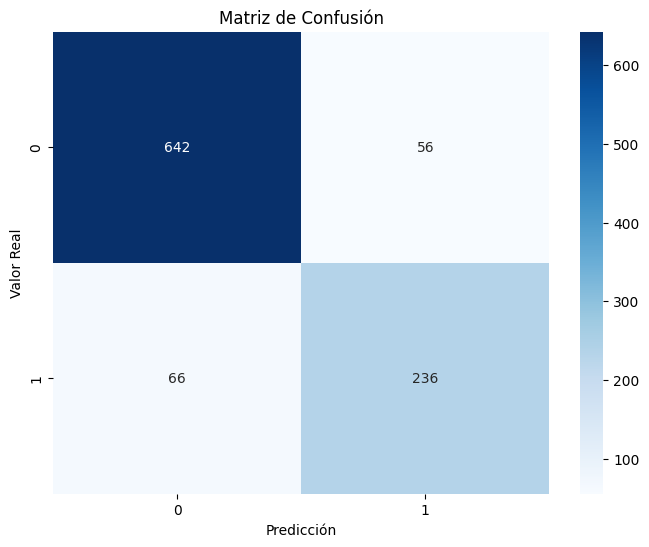


5. Guardando modelo y preprocesador
Preprocesador guardado en: ..\models\health_preprocessor_20251029_222315.joblib
Modelo guardado en: ..\models\health_classifier_20251029_222315.joblib

6. Ejemplo de predicción

Datos de ejemplo:
      age  weight  height exercise  sleep  sugar_intake  smoking  alcohol  \
3572   42      58     159      low    7.7           NaN        0        0   
4640   73      57     173      low    6.3           NaN        0        0   
4590   42      81     163   medium    6.7           NaN        0        0   
3192   39      85     160     high    5.9           NaN        0        0   
231    75      73     157   medium    8.5           NaN        0        0   

     married     profession   bmi  
3572     yes         doctor  22.9  
4640      no         driver  19.0  
4590     yes        teacher  30.5  
3192      no  office_worker  33.2  
231       no        student  29.6  

Predicciones:
['low' 'high' 'high' 'high' 'high']

Características más importantes:
   

C:\Users\Fernando Estrada\AppData\Roaming\Python\Python312\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['sugar_intake']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


In [24]:
# 1. División de datos en entrenamiento y prueba
print("1. División de datos en train/test")
X = df.drop('health_risk', axis=1)
y = df['health_risk']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Tamaño del conjunto de entrenamiento: {X_train.shape}")
print(f"Tamaño del conjunto de prueba: {X_test.shape}")
print("\nDistribución de clases:")
print("Train:", y_train.value_counts(normalize=True))
print("Test:", y_test.value_counts(normalize=True))

# 2. Aplicar transformaciones al conjunto de entrenamiento
print("\n2. Aplicando transformaciones al conjunto de entrenamiento")
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

print(f"\nForma de los datos transformados:")
print(f"Train: {X_train_transformed.shape}")
print(f"Test: {X_test_transformed.shape}")

# 3. Entrenar el modelo con los datos transformados
print("\n3. Entrenando el modelo")
clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    random_state=42
)

clf.fit(X_train_transformed, y_train)

# 4. Evaluar el modelo
print("\n4. Evaluación del modelo")
y_pred = clf.predict(X_test_transformed)
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

# Visualizar matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.ylabel('Valor Real')
plt.xlabel('Predicción')
plt.show()

# 5. Guardar el modelo y el preprocesador
print("\n5. Guardando modelo y preprocesador")
# Crear directorio para modelos si no existe
model_dir = Path('../models')
model_dir.mkdir(exist_ok=True)

# Guardar el preprocesador
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
preprocessor_filename = model_dir / f'health_preprocessor_{timestamp}.joblib'
joblib.dump(preprocessor, preprocessor_filename)
print(f"Preprocesador guardado en: {preprocessor_filename}")

# Guardar el modelo
model_filename = model_dir / f'health_classifier_{timestamp}.joblib'
joblib.dump(clf, model_filename)
print(f"Modelo guardado en: {model_filename}")

# 6. Ejemplo de uso del modelo guardado
print("\n6. Ejemplo de predicción")
# Cargar el modelo y preprocesador
loaded_preprocessor = joblib.load(preprocessor_filename)
loaded_model = joblib.load(model_filename)

# Crear un ejemplo de datos
sample_data = X_test.iloc[:5]
print("\nDatos de ejemplo:")
print(sample_data)

# Transformar y predecir
sample_transformed = loaded_preprocessor.transform(sample_data)
predictions = loaded_model.predict(sample_transformed)
print("\nPredicciones:")
print(predictions)

# 7. Guardar información de features importantes
feature_names = (
    continuous_features +
    discrete_features +
    ordinal_features +
    [f"{feature}_{cat}" for feature, categories in zip(categorical_features, categorical_encoder.categories_)
     for cat in categories[1:]]
)

feature_importance = pd.DataFrame({
    'feature': feature_names[:len(clf.feature_importances_)],
    'importance': clf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nCaracterísticas más importantes:")
print(feature_importance.head(10))

In [13]:
# Verificar los tipos de datos
print("Tipos de datos de cada columna:")
print(df.dtypes)

print("\nValores únicos en cada columna:")
for column in df.columns:
    print(f"\n{column}:")
    print(df[column].value_counts().head())

Tipos de datos de cada columna:
age               int64
weight            int64
height            int64
exercise         object
sleep           float64
sugar_intake     object
smoking          object
alcohol          object
married          object
profession       object
bmi             float64
health_risk      object
dtype: object

Valores únicos en cada columna:

age:
age
77    102
52    101
66     99
38     95
64     95
Name: count, dtype: int64

weight:
weight
98     98
102    98
61     96
93     90
103    90
Name: count, dtype: int64

height:
height
157    119
160    113
192    111
188    109
161    108
Name: count, dtype: int64

exercise:
exercise
medium    1985
low       1272
high      1000
none       743
Name: count, dtype: int64

sleep:
sleep
6.8    140
7.0    136
6.6    136
7.1    136
7.4    133
Name: count, dtype: int64

sugar_intake:
sugar_intake
medium    2511
low       1484
high      1005
Name: count, dtype: int64

smoking:
smoking
no     4023
yes     977
Name: count, dty